## 範例重點
* 學習如何在 keras 中撰寫自定義的 loss function
* 知道如何在訓練時使用自定義的 loss function

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)

撰寫重點：
1. Loss function 是探討真實值與預測值的差異，因此自定義 Loss function 時務必要同時輸入真實值與預測值
2. 在 tensorflow 中的運算都是以 tensor 的資料型態進行，因此在輸出 Loss 值時務必要轉成 tensor 資料型態

"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
"""
# 在 compile 時，使用自定義的 loss function
"""
model.compile(loss=focal_loss(), metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True, 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 - 5s - loss: 6.0060 - accuracy: 0.3274 - val_loss: 6.5181 - val_accuracy: 0.2197 - 5s/epoch - 99ms/step
Epoch 2/50
49/49 - 4s - loss: 4.4162 - accuracy: 0.4376 - val_loss: 5.4781 - val_accuracy: 0.3300 - 4s/epoch - 82ms/step
Epoch 3/50
49/49 - 5s - loss: 3.9885 - accuracy: 0.4802 - val_loss: 4.7376 - val_accuracy: 0.4029 - 5s/epoch - 96ms/step
Epoch 4/50
49/49 - 4s - loss: 3.7019 - accuracy: 0.5083 - val_loss: 4.3440 - val_accuracy: 0.4424 - 4s/epoch - 86ms/step
Epoch 5/50
49/49 - 4s - loss: 3.4963 - accuracy: 0.5269 - val_loss: 4.1262 - val_accuracy: 0.4623 - 4s/epoch - 84ms/step
Epoch 6/50
49/49 - 4s - loss: 3.3134 - accuracy: 0.5468 - val_loss: 4.0572 - val_accuracy: 0.4685 - 4s/epoch - 82ms/step
Epoch 7/50
49/49 - 4s - loss: 3.1352 - accuracy: 0.5668 - val_loss: 3.9802 - val_accuracy: 0.4722 - 4s/epoch - 82ms/step
Epoch 8/50
49/49 - 4s - loss: 2.9825 - accuracy: 0.5826 - val_loss: 3.9827 - val_accuracy: 0.4808 - 4s/epoch - 76ms/step
Epoch 9/50
49/49 - 5s - loss: 2.

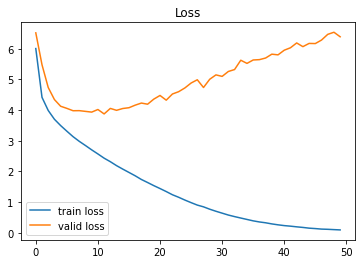

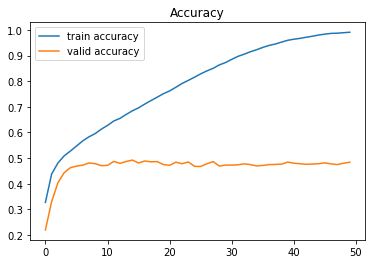

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果
